# Rotten Tomatoes PJT



## In this project, I will be analyzing certified "fresh" movies on Netflix (March 2023) by Rotten Tomatoes.

### 1. Scraping the data from Rotten Tomatoes
I will scrape netflix movie information from the certified fresh movies page on Rotten Tomatoes.
It contains the top fresh movies on netflix certified by Rotten Tomatoes.

### 2. Save the data in pandas dataframe, and clean the data
I will then save the scraped data in a pandas dataframe, and clean the data if necessary.

### 3. Perform exploratory data analysis and find some insights from the data
I will go over the data, and try to find some insights about the highly rated movies on Netflix.

## Scrape the data from Rotten Tomatoes

In [77]:
# Import necessary libraries

import pandas as pd
import numpy as np
import time
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By

In [4]:
# Install webdriver
driver = webdriver.Chrome(ChromeDriverManager().install())

[WDM] - Downloading: 100%|█████████████████| 8.84M/8.84M [00:00<00:00, 13.0MB/s]
/var/folders/vk/y7f8_5d11n9gb0mnty5f0h9h0000gn/T/ipykernel_60762/1314421596.py:2: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install())


## Get Elements from the page url

In [5]:
# Get Rotten Tomatoes netflix recommendation list page url
page_url = "https://www.rottentomatoes.com/browse/movies_at_home/affiliates:netflix~critics:certified_fresh"
driver.implicitly_wait(5)
driver.get(page_url)

## Scroll the page to load all the data

In [6]:
from selenium.common.exceptions import ElementNotInteractableException

# Get the total scroll size
last_height = driver.execute_script('return document.documentElement.scrollHeight')

# Scroll until the scroll size doesn't change
while True:
    # Scroll to the end
    driver.execute_script('window.scrollTo(0, document.documentElement.scrollHeight)')
    time.sleep(3)
    
    # Click the load more button
    try:
        button = driver.find_element(By.XPATH, '//button[text()="Load more"]')
        button.click()
        time.sleep(3)
        
        # Get the current height
        now_height = driver.execute_script('return document.documentElement.scrollHeight')
        
    except ElementNotInteractableException:
        # If I can't load more items, break the loop
        break

        
time.sleep(1.5)



## Get all the data from the loaded page

In [7]:
# Get title, and start_date
title = driver.find_elements(By.XPATH, ".//span[@data-qa='discovery-media-list-item-title']")
start_date = driver.find_elements(By.XPATH, ".//span[@data-qa='discovery-media-list-item-start-date']")

title_list = []

for t in title:
    title_list.append(t.text)

start_date_list = []

for sd in start_date:
    start_date_list.append(sd.text)

# Get review score and sentiment
score_pairs = driver.find_elements(By.XPATH, ".//score-pairs")
aud_sentiment = []
aud_score = []
crit_sentiment = []
crit_score = []

for pair in score_pairs:
    aud_sentiment.append(pair.get_attribute("audiencesentiment"))
    aud_score.append(pair.get_attribute("audiencescore"))
    crit_sentiment.append(pair.get_attribute("criticssentiment"))
    crit_score.append(pair.get_attribute("criticsscore"))


## Put all the data into a pandas dataframe

In [9]:
# Put data into a pandas dataframe
rotten_df = pd.DataFrame({'title':title_list, 'start_date':start_date_list, 'aud_sentiment':aud_sentiment,
              'aud_score':aud_score, 'crit_sentiment':crit_sentiment,
              'crit_score':crit_score})

### Get Data Info

In [10]:
rotten_df.head()

,title,start_date,aud_sentiment,aud_score,crit_sentiment,crit_score
0,The Woman King,"Streaming Dec 13, 2022",positive,99,positive,94
1,Emily the Criminal,"Streaming Oct 28, 2022",positive,79,positive,94
2,Leave No Trace,"Streaming Sep 25, 2018",positive,80,positive,100
3,The Stranger,"Streaming Oct 19, 2022",positive,67,positive,91
4,Glass Onion: A Knives Out Mystery,"Streaming Dec 23, 2022",positive,92,positive,92


In [11]:
rotten_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           258 non-null    object
 1   start_date      258 non-null    object
 2   aud_sentiment   258 non-null    object
 3   aud_score       258 non-null    object
 4   crit_sentiment  258 non-null    object
 5   crit_score      258 non-null    object
dtypes: object(6)
memory usage: 12.2+ KB


In [12]:
# Print data info
print('Total number of data:', rotten_df.shape[0]*rotten_df.shape[1])
print('Total number of null values: {} = {:.2f}% of data'.format(rotten_df.isnull().sum().sum(),
     (rotten_df.isnull().sum().sum()/rotten_df.shape[0]*rotten_df.shape[1])))

Total number of data: 1548
Total number of null values: 0 = 0.00% of data


## Data Cleaning

### Find '' Values and exclude them from the data

In [13]:
rotten_df.query('aud_score == ""')

,title,start_date,aud_sentiment,aud_score,crit_sentiment,crit_score
174,Disappearance at Clifton Hill,"Streaming Feb 28, 2020",,,positive,76
237,Rolling Thunder Revue: A Bob Dylan Story by Ma...,"Streaming Jun 12, 2019",,,positive,92


In [14]:
rotten_df = rotten_df.query('aud_score != ""').copy()

In [17]:
# Copy the dataframe to csv so I can use it later on without scraping again.
rotten_df.to_csv('rotten_df.csv', index=False)

### Dataframe from the csv file (created)

In [71]:
# Read csv file back
rotten_df = pd.read_csv('rotten_df.csv')

### Change Data Type

In [72]:
# Need to get rid of "Streaming" text
rotten_df['start_date']

0      Streaming Dec 13, 2022
1      Streaming Oct 28, 2022
2      Streaming Sep 25, 2018
3      Streaming Oct 19, 2022
4      Streaming Dec 23, 2022
                ...          
251    Streaming Apr 28, 2017
252     Streaming Nov 7, 2017
253    Streaming Aug 26, 2020
254     Streaming Dec 4, 2018
255    Streaming Jan 19, 2017
Name: start_date, Length: 256, dtype: object

In [73]:
# Change start_date column to datetime
rotten_df['start_date'] = rotten_df['start_date'].apply(lambda x: x.split('Streaming')[1])
rotten_df['start_date'] = pd.to_datetime(rotten_df['start_date'])

# Change aud_score, crit_score to int
rotten_df[['aud_score','crit_score']] = rotten_df[['aud_score','crit_score']].astype(int)

In [74]:
rotten_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   title           256 non-null    object        
 1   start_date      256 non-null    datetime64[ns]
 2   aud_sentiment   256 non-null    object        
 3   aud_score       256 non-null    int64         
 4   crit_sentiment  256 non-null    object        
 5   crit_score      256 non-null    int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 12.1+ KB


### Add year_month, year, month column

In [159]:
# add year-month column from the start_date
rotten_df['year_month'] = rotten_df['start_date'].dt.strftime('%Y-%m')
rotten_df['month'] = rotten_df['start_date'].dt.month
rotten_df['year'] = rotten_df['start_date'].dt.year

## Perform EDA

## Questions to ask

#### 1) How is the release date distributed for fresh rated Netflix movies?
#### 2) How do critics and audience differ in giving out scores?
#### 3) What's the most popular titles? (by audience, and by critics)
#### 4) What's the relationship between sentiment and score?

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

### 1) How is the release date distributed for fresh-rated Netflix movies?

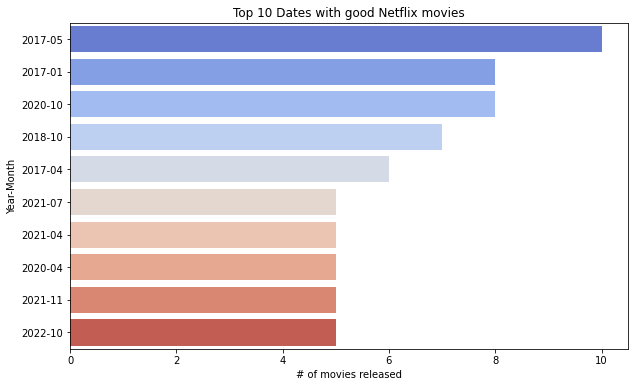

In [78]:
# When did many good movies from Netflix came out?
ym_cnt = rotten_df['year_month'].value_counts().reset_index()\
         .rename(columns={'index':'year_month','year_month':'count'})

# Barchart with Top 10 dates with the most "fresh" Netflix movies
f, ax = plt.subplots(1,1, figsize=(10,6))
sns.barplot(y='year_month', x='count', palette= 'coolwarm', data=ym_cnt.head(10))
ax.set_xlabel('# of movies released', fontsize=10)
ax.set_ylabel('Year-Month', fontsize=10)
ax.set_title('Top 10 Dates with good Netflix movies')
plt.show()

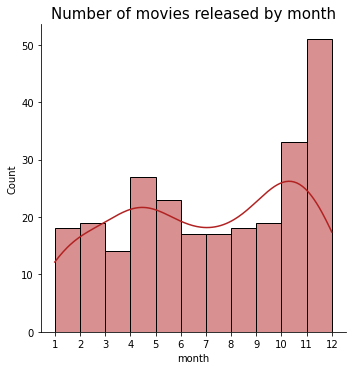

In [88]:
# Most popular month of release date among "fresh" Netflix movies
sns.displot(rotten_df['month'], bins=12, binwidth=1, color='firebrick', kde=True)
plt.title('Number of movies released by month', fontsize=15)

# Show all the month values
ax = plt.gca()
ax.set_xticks(range(1, 13))
plt.show()

<AxesSubplot:xlabel='year', ylabel='title'>

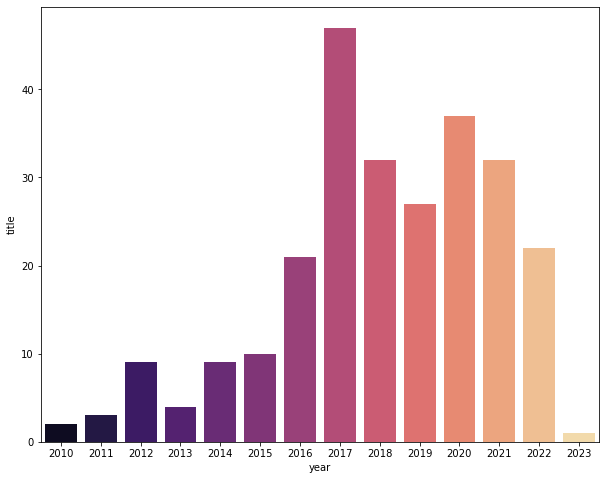

In [172]:
# Count the number of titles by year
year_cnt = rotten_df.groupby('year')['title'].count().reset_index()

# Most popular year of release date among "fresh" Netflix movies
f, ax = plt.subplots(1,1, figsize=(10,8))
sns.barplot(x='year', y='title', data=year_cnt, palette='magma', ax=ax)

### 2) How do audience and critics differ in giving out scores?

(0.0, 120.0)

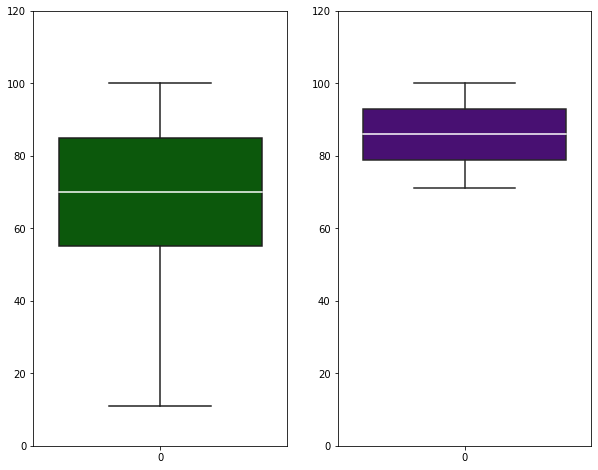

In [113]:
# Plot boxplot to see the different score distribution between audience and critics
f, ax = plt.subplots(1,2, figsize=(10,8))
sns.boxplot(aud_cnt['aud_score'], ax=ax[0], color='darkgreen', medianprops=dict(color='white'))
ax[0].set_ylim(0,120)
sns.boxplot(crit_cnt['crit_score'], ax=ax[1], color='indigo', medianprops=dict(color='white'))
ax[1].set_ylim(0,120)

In [174]:
# Median, 1st quartile, 3rd quartile value of audience and critics score
audience_median = aud_cnt['aud_score'].median()
critics_median = crit_cnt['crit_score'].median()
audience_1q = aud_cnt['aud_score'].quantile(0.25)
critics_1q = crit_cnt['crit_score'].quantile(0.25)
audience_3q = aud_cnt['aud_score'].quantile(0.75)
critics_3q = crit_cnt['crit_score'].quantile(0.75)
audience_std = aud_cnt['aud_score'].std()
critics_std = crit_cnt['crit_score'].std()

print(f"The median value of audience score is {audience_median}, and the median value of critics score is {critics_median}")
print(f"The 1q value of audience score is {audience_1q}, and the 1q value of critics score is {critics_1q}")
print(f"The 3q value of audience score is {audience_3q}, and the 3q value of critics score is {critics_3q}")
print(f"The standard deviation of audience score is {audience_std}, and the standard deviation of critics score is {critics_std}")

The median value of audience score is 70.0, and the median value of critics score is 86.0
The 1q value of audience score is 55.0, and the 1q value of critics score is 79.0
The 3q value of audience score is 85.0, and the 3q value of critics score is 93.0
The standard deviation of audience score is 19.753453042539807, and the standard deviation of critics score is 8.575224939243325


### Explore the relationship between audience score and critics score

In [117]:
# Get the 50, 80% score from audience, and critics score
print(np.percentile(aud_cnt['aud_score'], 50))
print(np.percentile(crit_cnt['crit_score'], 50))
print(np.percentile(aud_cnt['aud_score'], 80))
print(np.percentile(crit_cnt['crit_score'], 80))

70.0
86.0
88.0
94.4


In [118]:
# Divide the data into popular, neutral, unpopular groups with 80% and higher as popular group & 50% and higher as neutral, below 50% as unpopular
aud_bins = pd.cut(rotten_df['aud_score'], bins=[0,70,88,100], labels=['unpopular','neutral','popular'])
rotten_df['aud_popularity'] = aud_bins

crit_bins = pd.cut(rotten_df['crit_score'], bins=[0,86,94.4,100], labels=['unpopular','neutral','popular'])
rotten_df['crit_popularity'] = crit_bins


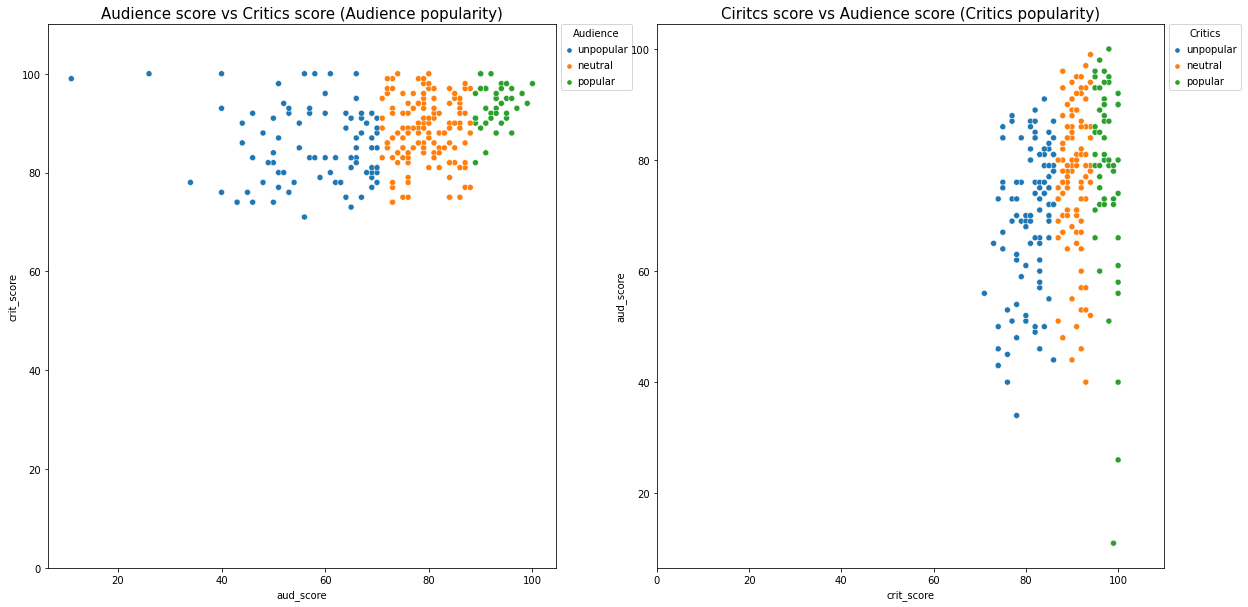

In [136]:
# Scatterplot between audience score and critics score with popularity hues

# First scatterplot with audience popularity
f, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].set_title('Audience score vs Critics score (Audience popularity)', fontsize=15)
sns.scatterplot(x='aud_score', y='crit_score', data=rotten_df, hue='aud_popularity', ax=ax[0])
ax[0].set_ylim(0,110)
ax[0].legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0., title='Audience', frameon=True, prop={'size': 10},
           title_fontsize=10, markerscale=0.6, labelspacing=0.6, handletextpad=0.5, handlelength=0.8)

# Second scatterplot with critics popularity
ax[1].set_title('Ciritcs score vs Audience score (Critics popularity)', fontsize=15)
sns.scatterplot(x='crit_score', y='aud_score', data=rotten_df, hue='crit_popularity', ax=ax[1])
ax[1].set_xlim(0,110)
ax[1].legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0., title='Critics', frameon=True, prop={'size': 10},
           title_fontsize=10, markerscale=0.6, labelspacing=0.6, handletextpad=0.5, handlelength=0.8)


### 3) What are some of the most popular titles by audience and critics?

### What are some titles popular among audience but not popular among critics?

In [137]:
aud_preferred = rotten_df.query('aud_popularity=="popular" and crit_popularity!="popular"')[['title','aud_score','crit_score']].reset_index(drop=True)
crit_preferred = rotten_df.query('crit_popularity=="popular" and aud_popularity!="popular"')[['title','aud_score','crit_score']].reset_index(drop=True)

In [139]:
# Need to adjust scatterplot labels due to duplicated values below
aud_preferred[aud_preferred.duplicated(['aud_score','crit_score'], keep=False)].sort_values(by='aud_score')

,title,aud_score,crit_score
11,National Lampoon's Animal House,89,91
16,Philomena,89,91
22,Rumble: The Indians Who Rocked the World,89,91
9,The Imitation Game,91,90
21,Adam Sandler: 100% Fresh,91,90
5,The Harder They Fall,93,88
6,The Bad Guys,93,88


### Scatterplot of titles only popular among audience, or critics

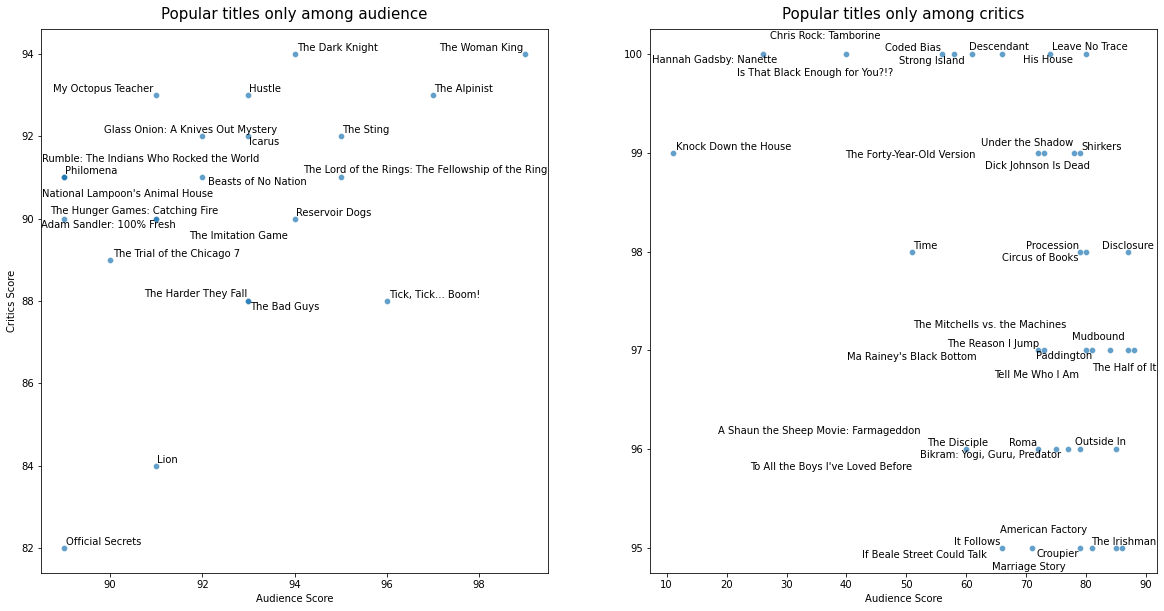

In [140]:
from adjustText import adjust_text

f, ax = plt.subplots(1,2, figsize=(20,10))

# Plot 1st scatterplot (popular among audience)
sns.scatterplot(x='aud_score', y='crit_score', data=aud_preferred, alpha=0.7, ax=ax[0])

# Add labels to the scatterplot
texts1 = []
for i, label in enumerate(aud_preferred['title']):
    texts1.append(ax[0].text(aud_preferred.loc[i, 'aud_score'], aud_preferred.loc[i, 'crit_score'], label))

# Adjust label positions 
adjust_text(texts1, ax=ax[0])

# Set x, ylabel
ax[0].set_xlabel('Audience Score')
ax[0].set_ylabel('Critics Score')

# Set title
ax[0].set_title('Popular titles only among audience', fontsize=15, pad=10)

# Plot 2nd scatterplot (popular amdong critics)
sns.scatterplot(x='aud_score', y='crit_score', data=crit_preferred, alpha=0.7, ax=ax[1])

# Add labels to the scatterplot
texts2 = []
for i, label in enumerate(crit_preferred['title']):
    texts2.append(ax[1].text(crit_preferred.loc[i, 'aud_score'], crit_preferred.loc[i, 'crit_score'], label))

# Adjust label positions 
adjust_text(texts2, ax=ax[1])

# Set x, ylabel
ax[1].set_xlabel('Audience Score')
ax[1].set_ylabel('')

# Set title
ax[1].set_title('Popular titles only among critics', fontsize=15, pad=10)

plt.show()

### 4) What's the relationship between sentiment and score?

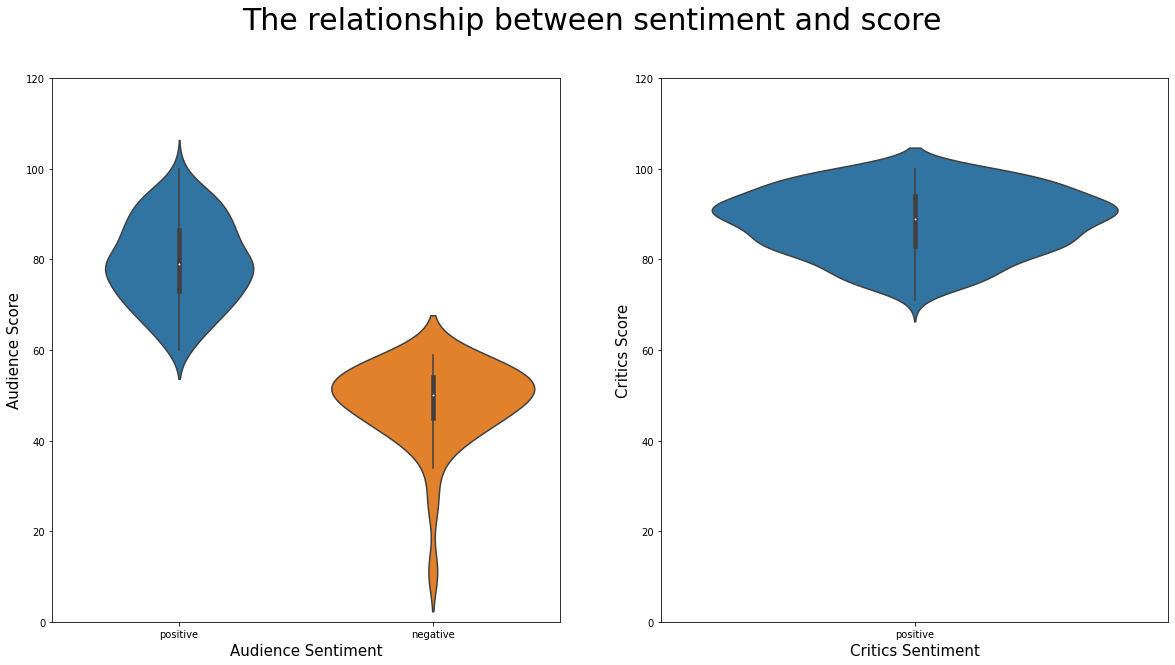

In [156]:
# Create a violinplot of the relationship bewteen sentiment and score
f, ax = plt.subplots(1,2, figsize=(20,10))

# Audience violinplot
sns.violinplot(x='aud_sentiment', y='aud_score', data = rotten_df, ax=ax[0])
ax[0].set_ylim(bottom=0, top=120)
ax[0].set_xlabel('Audience Sentiment', fontsize=15)
ax[0].set_ylabel('Audience Score', fontsize=15)

# Critics violinplot
sns.violinplot(x='crit_sentiment', y='crit_score', data = rotten_df, ax=ax[1])
ax[1].set_ylim(bottom=0, top=120)
ax[1].set_xlabel('Critics Sentiment', fontsize=15)
ax[1].set_ylabel('Critics Score', fontsize=15)
     
plt.suptitle('The relationship between sentiment and score', fontsize=30)
plt.show()

### Data Analysis

### 1) How is the release date distributed for fresh-rated Netflix movies?

- The most popular release dates(months) for fresh-rated Netflix movies were April, October, and November. 
- The number of popular titles increased over time, and reached its peak in 2017 and gradually decreased after 2017. Maybe Covid-19 had some impact on such decline, but since the pivot occurred in 2018, other factors should have played their part as well. We need more data to come up with the hypothesis.

### 2) How do audience and critics differ in giving out scores?

- First of all, the audience score has higher standard deviation with 19.75, and 1q value 55, median value 70, and 3q value 85. 
- The critics score has lower standard deviation with 8.57, and 1q value 79, median value 86, and 3q value 93.
- So it seems like critics tend to give higher, similar scores where as audience sometimes gives very low score if a movie is not entertaining. 
- You can see from the relationship scattergram that even the titles unpopular among audience got pretty high scores from critics.
- However, higher critics score didn't guarantee high audience score, especially the most popular movies from critics had some very low audience scores. 

### 3) What are some of the most popular titles by audience and critics?

- Titles that are liked by audience but disliked by critics: Official Secrets, Lion, The Bad Guys, Tick, Tick... Boom!
- Titles that are liked by critics but disliked by audience: Knock Down the House, Hannah Gadsby: Nanette, Is That Black Enough for You?!?, Chris Rock: Tamborine
- We need more data about titles to analyze why such difference is demonstrated. One possible reason is audience and critics might prefer certain genres respectively.
- We need the genre or movie category tag information to prove the assumption.

### 4) Explore the relationship between sentiment and score

- For audience, negative sentiment titles had very low median score (below 60), and positive sentiment titles' median score hovered arouned 80.
- Critics, on the other hand, didn't have any negative sentiment. This could be because critics do not want to displease the movie distributor or production team, which could impact their business opportunities as critics.